Found 551 folders. Processing...

### Comparative Analysis Table ###


,ID,C_Vars,Btor_Vars,C_Locs,Btor_Locs,C_Edges,Btor_Edges,C_Stmts,Btor_Stmts,Ratio_Stmts (Btor/C)
0,Huffman_dec.yml,448,193,5,3,4,3,990,285,0.29
1,Huffman_enc.yml,240,103,5,3,4,3,516,115,0.22
2,adding.1.prop1-back-serstep.yml,378,138,5,3,4,3,940,178,0.19
3,adding.1.prop1-func-interl.yml,307,107,5,3,4,3,760,130,0.17
4,adding.2.prop1-back-serstep.yml,378,138,5,3,4,3,940,178,0.19
...,...,...,...,...,...,...,...,...,...,...
546,train-gate.6.prop1-func-interl.yml,3483,1197,5,3,4,3,8056,1326,0.16
547,train-gate.7.prop1-back-serstep.yml,4551,1656,5,3,4,3,10700,1997,0.19
548,train-gate.7.prop1-func-interl.yml,3900,1340,5,3,4,3,9016,1483,0.16
549,twocount2.yml,30,10,5,3,4,3,82,22,0.27


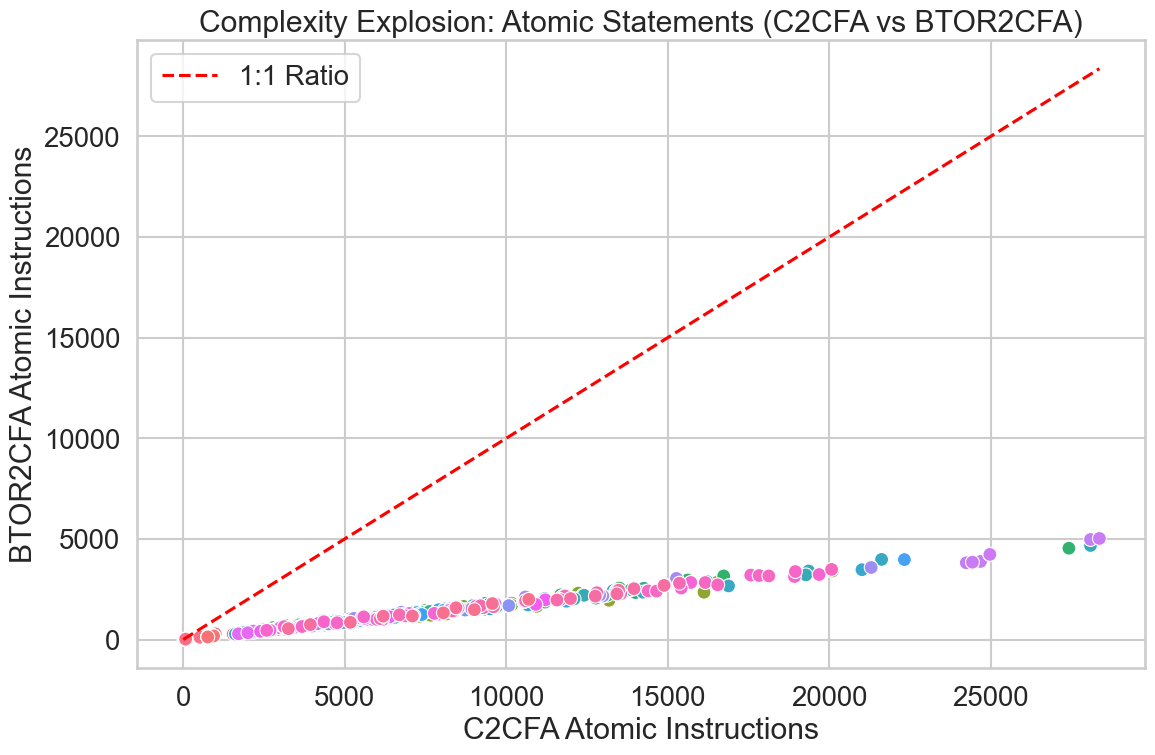

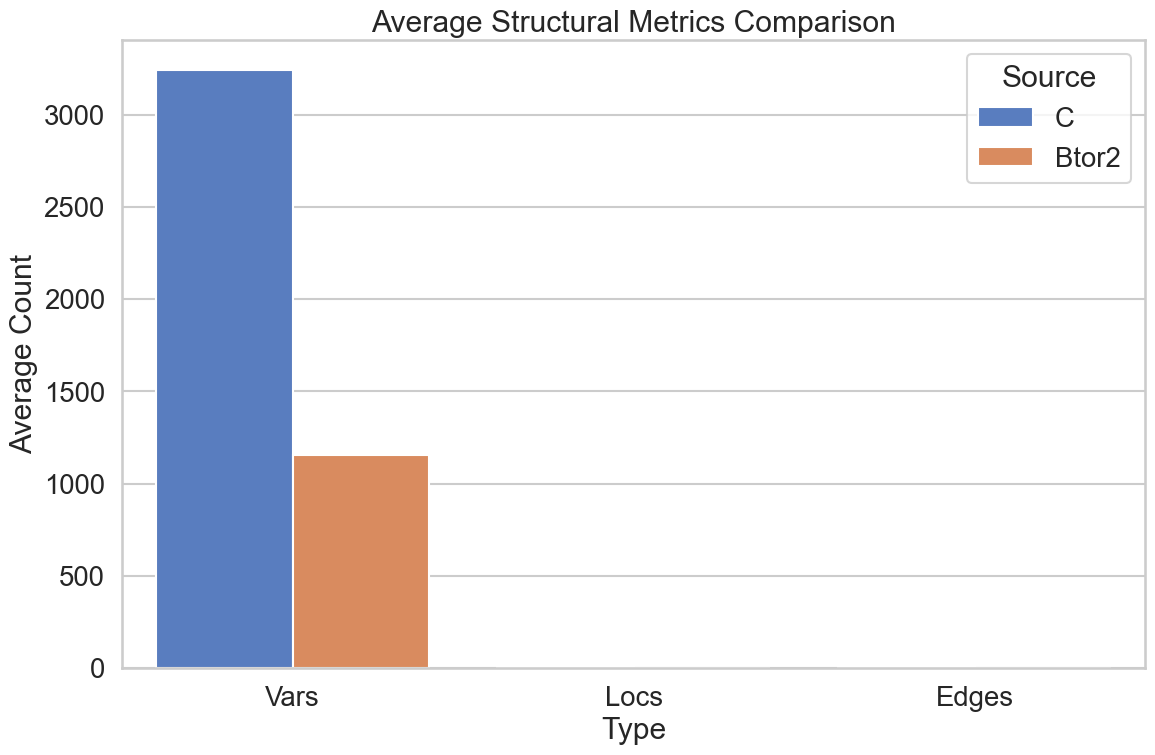

------------------------------
Average Ratio (Btor/C): 0.1783
------------------------------


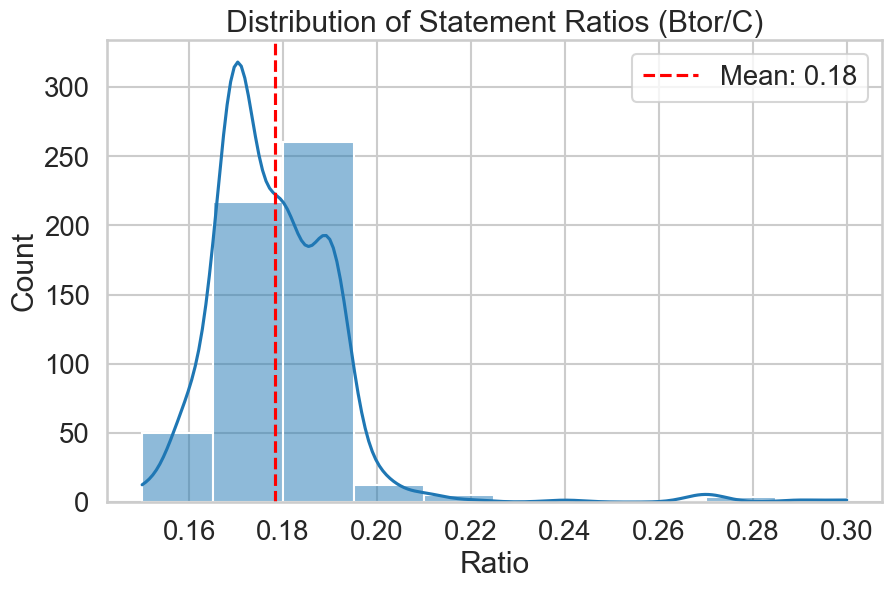

In [7]:
import os
import json
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Update this path to point to the parent folder containing the numbered subfolders (e.g., "000", "001")
ROOT_DIR = "json_files"  

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def get_atomic_instruction_count(label_data):
    """
    Recursively calculates the number of atomic instructions.
    - Unpacks 'SequenceLabel' to count its children.
    - Counts 'StmtLabel' as 1.
    """
    if not label_data:
        return 0
    
    # Get the type of the label
    l_type = label_data.get("type", "")
    
    # Case 1: Sequence Label (contains a list of labels)
    if "SequenceLabel" in l_type:
        sub_labels = label_data.get("labels", [])
        return sum(get_atomic_instruction_count(sub) for sub in sub_labels)
    
    # Case 2: Nondet Label (Choice block, contains a list of labels)
    elif "NondetLabel" in l_type:
        sub_labels = label_data.get("labels", [])
        return sum(get_atomic_instruction_count(sub) for sub in sub_labels)

    # Case 3: Atomic Statement
    elif "StmtLabel" in l_type:
        return 1
    
    # Case 4: Other labels (Empty, Comments, etc.)
    return 0

def parse_xcfa(filepath):
    """
    Parses a single XCFA JSON file and extracts metrics.
    """
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
            
        stats = {
            "vars": 0,
            "locs": 0,
            "edges": 0,
            "atomic_stmts": 0
        }
        
        # Iterate through all procedures (usually 'main')
        for proc in data.get("procedures", []):
            # 1. Count Variables (Vars list + Params list)
            stats["vars"] += len(proc.get("vars", [])) + len(proc.get("params", []))
            
            # 2. Count Locations (Nodes)
            stats["locs"] += len(proc.get("locs", []))
            
            # 3. Count Edges
            edges = proc.get("edges", [])
            stats["edges"] += len(edges)
            
            # 4. Count Atomic Instructions (Recursive Label Analysis)
            for edge in edges:
                label = edge.get("label", {})
                stats["atomic_stmts"] += get_atomic_instruction_count(label)
                
        return stats
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

# ==========================================
# 3. MAIN PROCESSING LOOP
# ==========================================

data_rows = []

# Find all subdirectories
subfolders = sorted([f.path for f in os.scandir(ROOT_DIR) if f.is_dir()])

print(f"Found {len(subfolders)} folders. Processing...")

for folder in subfolders:
    folder_name = os.path.basename(folder)
    
    # Define paths for the pair
    c_path = os.path.join(folder, "c-xcfa.json")
    btor_path = os.path.join(folder, "btor2-xcfa.json")
    
    # Proceed only if both files exist
    if os.path.exists(c_path) and os.path.exists(btor_path):
        c_stats = parse_xcfa(c_path)
        btor_stats = parse_xcfa(btor_path)
        
        if c_stats and btor_stats:
            data_rows.append({
                "ID": folder_name,
                # C Metrics
                "C_Vars": c_stats["vars"],
                "C_Locs": c_stats["locs"],
                "C_Edges": c_stats["edges"],
                "C_Stmts": c_stats["atomic_stmts"],
                # BTOR2 Metrics
                "Btor_Vars": btor_stats["vars"],
                "Btor_Locs": btor_stats["locs"],
                "Btor_Edges": btor_stats["edges"],
                "Btor_Stmts": btor_stats["atomic_stmts"],
            })

# Create DataFrame
df = pd.DataFrame(data_rows)

# ==========================================
# 4. COMPARATIVE TABLE
# ==========================================

# Calculate Ratios to highlight differences
if not df.empty:
    df["Ratio_Stmts (Btor/C)"] = (df["Btor_Stmts"] / df["C_Stmts"]).round(2)
    df["Ratio_Vars (Btor/C)"] = (df["Btor_Vars"] / df["C_Vars"]).round(2)

    print("\n### Comparative Analysis Table ###")
    # Displaying a clean table with the specific columns you asked for
    display_cols = ["ID", "C_Vars", "Btor_Vars", "C_Locs", "Btor_Locs", 
                    "C_Edges", "Btor_Edges", "C_Stmts", "Btor_Stmts", "Ratio_Stmts (Btor/C)"]
    display(df[display_cols])
else:
    print("No valid data found. Check your ROOT_DIR.")

# ==========================================
# 5. VISUALIZATION PLOTS
# ==========================================

if not df.empty:
    sns.set_context("talk", font_scale=1.2)
    sns.set_style("whitegrid")
    
    # ==========================================
    # Plot 1: Scatter Plot of Complexity
    # ==========================================
    plt.figure(figsize=(12, 8))
    
    # Scatter plot showing C vs Btor2 statements
    sns.scatterplot(data=df, x="C_Stmts", y="Btor_Stmts", hue="ID", s=100, legend=False)
    
    # Add a diagonal line (x=y) to visualize expansion
    max_val = max(df["C_Stmts"].max(), df["Btor_Stmts"].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label="1:1 Ratio")
    
    plt.title("Complexity Explosion: Atomic Statements (C2CFA vs BTOR2CFA)")
    plt.xlabel("C2CFA Atomic Instructions")
    plt.ylabel("BTOR2CFA Atomic Instructions")
    plt.legend()
    plt.tight_layout()
    plt.show() # Render the first plot

    # ==========================================
    # Plot 2: Bar Chart comparison of Average Metrics
    # ==========================================
    plt.figure(figsize=(12, 8))
    
    # Prepare data for the bar chart
    avg_df = df[["C_Vars", "Btor_Vars", "C_Locs", "Btor_Locs", "C_Edges", "Btor_Edges"]].mean().reset_index()
    avg_df.columns = ["Metric", "Average Count"]
    
    # Extract source (C vs Btor) and Type (Vars/Locs/Edges) for coloring and grouping
    avg_df["Source"] = avg_df["Metric"].apply(lambda x: "C" if x.startswith("C") else "Btor2")
    avg_df["Type"] = avg_df["Metric"].apply(lambda x: x.split("_")[1])
    
    # Bar plot
    sns.barplot(data=avg_df, x="Type", y="Average Count", hue="Source", palette="muted")
    
    plt.title("Average Structural Metrics Comparison")
    plt.tight_layout()
    plt.show() # Render the second plot

    if not df.empty:
        # Calculate the mean of the Ratio column
        avg_ratio = df["Ratio_Stmts (Btor/C)"].mean()
        
        print("-" * 30)
        print(f"Average Ratio (Btor/C): {avg_ratio:.4f}")
        print("-" * 30)
        
        # Optional: Visualizing the distribution of ratios
        plt.figure(figsize=(10, 6))
        sns.histplot(df["Ratio_Stmts (Btor/C)"], kde=True, bins=10)
        plt.axvline(avg_ratio, color='r', linestyle='--', label=f'Mean: {avg_ratio:.2f}')
        plt.title("Distribution of Statement Ratios (Btor/C)")
        plt.xlabel("Ratio")
        plt.legend()
        plt.show()

In [6]:
import xml.etree.ElementTree as ET
import pandas as pd

# ==========================================
# 1. PARSING FUNCTION
# ==========================================
def parse_benchexec_xml(file_path):
    """
    Parses a BenchExec XML results file and returns a DataFrame.
    """
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        
        for run in root.findall('run'):
            record = {}
            record['name'] = run.get('name')
            
            # Extract values
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                
                if title == 'cputime':
                    try:
                        record['cputime'] = float(value.replace('s', ''))
                    except (ValueError, AttributeError):
                        record['cputime'] = None
                        
                elif title == 'memory':
                    try:
                        record['memory'] = int(value.replace('B', ''))
                    except (ValueError, AttributeError):
                        record['memory'] = None
                        
                elif title == 'status':
                    record['status'] = value
                    
                elif title == 'category':
                    record['category'] = value
            
            # Fallback for missing category
            if 'category' not in record:
                if 'status' in record:
                    status_lower = record['status'].lower()
                    if 'unknown' in status_lower:
                        record['category'] = 'unknown'
                    elif 'error' in status_lower:
                        record['category'] = 'error'
                    elif 'timeout' in status_lower:
                        record['category'] = 'unknown' # Timeouts are usually "unknown"
                    else:
                        record['category'] = 'correct' # Default to correct/wrong if not error/unknown
                        
            data.append(record)
            
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return pd.DataFrame()

# ==========================================
# 2. LOAD DATA
# ==========================================
# Update these filenames if they are in a different directory
file_c = "xcfa_analyses\\fight-xcfa.2025-12-07_11-41-58.results.c-xcfa.c.xml"
file_btor = "xcfa_analyses\\fight-xcfa.2025-12-07_11-41-58.results.btor2-xcfa.btor2.xml"

df_c = parse_benchexec_xml(file_c)
df_btor = parse_benchexec_xml(file_btor)

# ==========================================
# 3. CALCULATE STATISTICS (UPDATED)
# ==========================================

def calculate_summary(df, label):
    if df.empty:
        return {"Dataset": label}
        
    total_runs = len(df)
    
    # Average CPU and Memory
    avg_cpu = df['cputime'].mean()
    avg_mem_mb = df['memory'].mean() / (1024 * 1024)
    
    # Count specific categories
    # 'Error' usually implies a tool crash or internal failure
    error_count = len(df[df['category'] == 'error'])
    
    # 'Unknown' count
    unknown_count = len(df[df['category'] == 'unknown'])
    
    # Success Calculation:
    # Based on user input: "If the category is 'unknown' then it is considered a success"
    # This implies Success = Total - Errors (i.e., Stability Rate)
    success_count = total_runs - error_count
    
    success_rate = (success_count / total_runs) * 100 if total_runs > 0 else 0
    
    return {
        "Dataset": label,
        "Avg CPU Time (s)": round(avg_cpu, 2),
        "Avg Memory (MB)": round(avg_mem_mb, 2),
        "Errors (Crashes)": error_count,
        "Unknowns (Count)": unknown_count,
        "Success Rate (Non-Crash %)": f"{success_rate:.2f}%",
        "Total Runs": total_runs
    }

# Create Summary List
summary_data = []
summary_data.append(calculate_summary(df_c, "C-XCFA"))
summary_data.append(calculate_summary(df_btor, "BTOR2-XCFA"))

# ==========================================
# 4. DISPLAY TABLE
# ==========================================
summary_df = pd.DataFrame(summary_data)

print("### Performance & Stability Analysis ###")
display(summary_df)

### Performance & Stability Analysis ###


,Dataset,Avg CPU Time (s),Avg Memory (MB),Errors (Crashes),Unknowns (Count),Success Rate (Non-Crash %),Total Runs
0,C-XCFA,141.02,1878.00,171,525,75.43%,696
1,BTOR2-XCFA,22.42,461.02,9,689,98.71%,698
